In [1]:
#导入需要的包
%matplotlib inline
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
import paddlets
from paddlets import TSDataset
from paddlets import TimeSeries
from paddlets.models.forecasting import MLPRegressor, LSTNetRegressor
from paddlets.transform import Fill, StandardScaler
from paddlets.metrics import MSE, MAE
import warnings
warnings.filterwarnings('ignore')

C:\Users\82516\.conda\envs\paddle1\lib\site-packages\paddlets\utils\backtest.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Iterable


# 单时间序列预测任务

In [2]:
# 查看位置
import os
print(os.path.abspath('.'))


D:\a_study\model\chuneng\WindChaser-master - 副本\data


In [3]:
# 计时器
import time
import warnings
from contextlib import contextmanager

import torch


class TimeCounter:
    names = dict()

    # Avoid instantiating every time
    @classmethod
    def count_time(cls, log_interval=1, warmup_interval=1, with_sync=True):
        assert warmup_interval >= 1

        def _register(func):
            if func.__name__ in cls.names:
                raise RuntimeError(
                    'The registered function name cannot be repeated!')
            # When adding on multiple functions, we need to ensure that the
            # data does not interfere with each other
            cls.names[func.__name__] = dict(
                count=0,
                pure_inf_time=0,
                log_interval=log_interval,
                warmup_interval=warmup_interval,
                with_sync=with_sync)

            def fun(*args, **kwargs):
                count = cls.names[func.__name__]['count']
                pure_inf_time = cls.names[func.__name__]['pure_inf_time']
                log_interval = cls.names[func.__name__]['log_interval']
                warmup_interval = cls.names[func.__name__]['warmup_interval']
                with_sync = cls.names[func.__name__]['with_sync']

                count += 1
                cls.names[func.__name__]['count'] = count

                if with_sync and torch.cuda.is_available():
                    torch.cuda.synchronize()
                start_time = time.perf_counter()

                result = func(*args, **kwargs)

                if with_sync and torch.cuda.is_available():
                    torch.cuda.synchronize()

                elapsed = time.perf_counter() - start_time

                if count >= warmup_interval:
                    pure_inf_time += elapsed
                    cls.names[func.__name__]['pure_inf_time'] = pure_inf_time

                    if count % log_interval == 0:
                        times_per_count = 1000 * pure_inf_time / (
                            count - warmup_interval + 1)
                        print(
                            f'[{func.__name__}]-{count} times per count: '
                            f'{times_per_count:.1f} ms',
                            flush=True)

                return result

            return fun

        return _register

    @classmethod
    @contextmanager
    def profile_time(cls,
                     func_name,
                     log_interval=1,
                     warmup_interval=1,
                     with_sync=True):
        assert warmup_interval >= 1
        warnings.warn('func_name must be globally unique if you call '
                      'profile_time multiple times')

        if func_name in cls.names:
            count = cls.names[func_name]['count']
            pure_inf_time = cls.names[func_name]['pure_inf_time']
            log_interval = cls.names[func_name]['log_interval']
            warmup_interval = cls.names[func_name]['warmup_interval']
            with_sync = cls.names[func_name]['with_sync']
        else:
            count = 0
            pure_inf_time = 0
            cls.names[func_name] = dict(
                count=count,
                pure_inf_time=pure_inf_time,
                log_interval=log_interval,
                warmup_interval=warmup_interval,
                with_sync=with_sync)

        count += 1
        cls.names[func_name]['count'] = count

        if with_sync and torch.cuda.is_available():
            torch.cuda.synchronize()
        start_time = time.perf_counter()

        yield

        if with_sync and torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.perf_counter() - start_time

        if count >= warmup_interval:
            pure_inf_time += elapsed
            cls.names[func_name]['pure_inf_time'] = pure_inf_time

            if count % log_interval == 0:
                times_per_count = 1000 * pure_inf_time / (
                    count - warmup_interval + 1)
                print(
                    f'[{func_name}]-{count} times per count: '
                    f'{times_per_count:.1f} ms',
                    flush=True)

In [4]:
# df = pd.read_csv('WTH3.csv', encoding='gbk')
# df = pd.read_csv('p5.csv', encoding='gbk')
df = pd.read_csv('5_6.csv', encoding='gbk')


In [5]:
df.head(-5)

,date,power (MW),wind direction at 100m (deg),wind speed at 100m (m/s),air temperature at 2m (K),surface air pressure (Pa),density at hub height (kg/m^3)
0,2017/11/1 4:00,39.5,3.50,237.3,8.60,834.0,39.0
1,2017/11/1 4:15,49.2,3.40,282.3,9.01,834.0,40.0
2,2017/11/1 4:30,54.9,3.80,238.2,9.19,834.0,41.0
3,2017/11/1 4:45,50.4,4.40,241.9,9.28,834.0,41.0
4,2017/11/1 5:00,48.7,4.50,263.7,9.67,834.0,41.0
...,...,...,...,...,...,...,...
5830,2017/12/31 21:30,23.3,3.16,133.8,-1.78,828.0,31.0
5831,2017/12/31 21:45,18.1,3.11,139.8,-1.67,828.0,30.0
5832,2017/12/31 22:00,13.4,2.92,130.3,0.06,828.0,26.0
5833,2017/12/31 22:15,11.2,3.24,147.3,-0.18,828.0,26.0


<AxesSubplot:xlabel='date'>

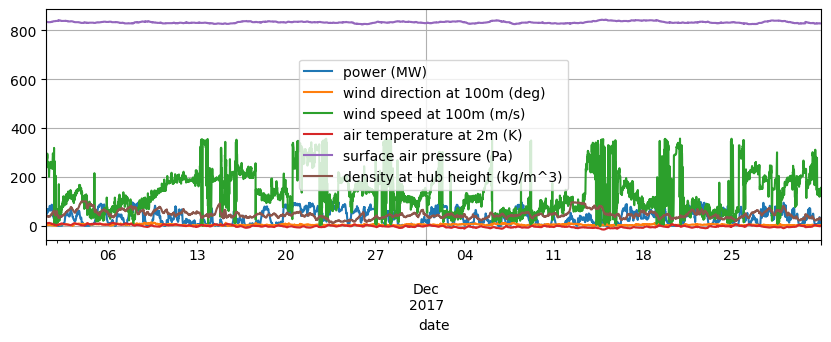

In [6]:
target_cov_dataset = TSDataset.load_from_dataframe(
    # df[df.TurbID==1],
    df,
    time_col='date',
    target_cols='power (MW)',
    observed_cov_cols=['wind direction at 100m (deg)', 'wind speed at 100m (m/s)', 'air temperature at 2m (K)', 'surface air pressure (Pa)', 'density at hub height (kg/m^3)'],
    # freq='10min',
    freq='15min',

    fill_missing_dates=True,
    fillna_method='pre'
)
target_cov_dataset.plot(['power (MW)', 'wind direction at 100m (deg)', 'wind speed at 100m (m/s)', 'air temperature at 2m (K)', 'surface air pressure (Pa)', 'density at hub height (kg/m^3)'])

In [7]:
target_cov_dataset.summary()


,power (MW),wind direction at 100m (deg),wind speed at 100m (m/s),air temperature at 2m (K),surface air pressure (Pa),density at hub height (kg/m^3)
missing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
count,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,33.503836,4.376476,137.491182,-1.764818,832.523938,46.620377
std,28.076948,2.353371,83.402592,5.006465,3.842710,15.936267
min,0.000000,0.000000,0.100000,-15.490000,824.000000,11.000000
25%,7.200000,2.670000,68.000000,-5.362500,830.000000,37.000000
50%,27.550000,4.100000,120.900000,-2.320000,832.000000,44.000000
75%,57.300000,5.880000,189.525000,1.330000,835.000000,54.000000
max,97.800000,14.070000,356.900000,12.340000,843.500000,100.000000


<AxesSubplot:xlabel='date'>

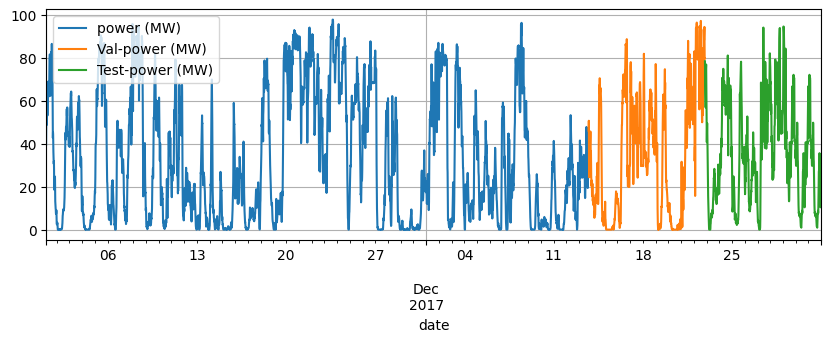

In [8]:
train_dataset, val_test_dataset = target_cov_dataset.split(0.7)
val_dataset, test_dataset = val_test_dataset.split(0.5)
train_dataset.plot(add_data=[val_dataset,test_dataset], labels=['Val', 'Test'])

In [9]:
lstm = LSTNetRegressor(
    in_chunk_len = 6 * 12,
    out_chunk_len = 12,
    max_epochs=100
)

In [10]:
# 计时器开始
time_counter = TimeCounter.profile_time('sleep3')
time_counter.__enter__()


lstm.fit(train_dataset, val_dataset)


# 计时器结束
time_counter.__exit__(None, None, None)

[2023-10-31 10:06:22,024] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 1349.177724| val_0_mae: 19.705025| 0:00:00s
[2023-10-31 10:06:22,600] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 471.001897| val_0_mae: 16.660749| 0:00:01s
[2023-10-31 10:06:23,180] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 337.144889| val_0_mae: 15.206416| 0:00:01s
[2023-10-31 10:06:23,758] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 281.327430| val_0_mae: 14.388252| 0:00:02s
[2023-10-31 10:06:24,330] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 255.035363| val_0_mae: 14.031037| 0:00:02s
[2023-10-31 10:06:24,898] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 240.666674| val_0_mae: 13.722488| 0:00:03s
[2023-10-31 10:06:25,482] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 228.040042| val_0_mae: 13.582709| 0:00:04s
[2023-10-31 10:06:26,064] [paddle

[sleep3]-1 times per count: 45675.9 ms


False

In [11]:
subset_test_pred_dataset = lstm.predict(val_dataset)
subset_test_dataset, _ = test_dataset.split(len(subset_test_pred_dataset.target))

In [12]:
# 模型评估
mae = MAE()
mae(subset_test_dataset, subset_test_pred_dataset)

# from sklearn.metrics import mean_squared_error, r2_score
# mse = mean_squared_error(subset_test_dataset, subset_test_pred_dataset)
# rmse = np.sqrt(mse)
# r2 = r2_score(subset_test_dataset, subset_test_pred_dataset)

# print('RMSE:', rmse)
# print('R^2:', r2)

{'power (MW)': 8.36301294962565}

In [ ]:
# 预测结果可视化
subset_test_dataset, _ = test_dataset.split(len(subset_test_pred_dataset.target))
subset_test_dataset.plot(add_data=subset_test_pred_dataset, labels=['Pred'])